In this homework assignment we will be transfer learning a Resnet-18 for Skin Cancer Classification using a subset of data from here: https://challenge2019.isic-archive.com/.

You will have to make a "File -> Save a copy in drive" this notebook in order to fill in sections of the code necessary to complete this implementation and evaluate your results.

Sections where you have to write code are denoted by a "# CODE HERE"
Note the class definitions are stored in collapsable cells.  For example,
the cell that reads resnet definition if you double click on it, will open
the code (including sections you have to fill in!).  You can recollapse the
cell by double clicking on the text again.

Aim for a Test Loss ~0.8!

In [ ]:
#@title Library Imports

# Google Drive Connection
from google.colab import drive
drive.mount("/content/drive")

# Data Access Libraries
import json
import os

# Image Libraries
from PIL import Image
import matplotlib.pyplot as plt

# Computational Libraries
import numpy as np
import torch
from torch import nn, optim
from torchvision import transforms

Mounted at /content/drive


In [ ]:
#@title Resnet Definition

class Resnet(nn.Module):
    def __init__(self, num_classes, loss_weights, params_path = None, learning_rate = 1e-3):
      '''
      num_classes: Number of different diagnosis classes possible
      loss_weights: Not all misclassifications are equal.  loss_weights is an array of length
                    num_classes, where each entry corresponds to how much we penalize a
                    misclassification for that class.  For example if we had two classes
                    and loss_weights was [1.0, 2.0], we'd double penalize errors where in reality
                    it was the second class and model said it was the first.
      params_path: Filepath to saved parameters, if any.
      learning_rate: Learning rate to be used for (Adam) optimizer.
      '''
      super().__init__()

      # Load pretrained resnet!
      self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained = True)
      
      '''
      self.model.fc references the final fully connected layer of the resnet model.  Currently
      this layer maps 512 hidden neurons to 1000 possible classification outputs.  We would
      like to replace this with a layer mapping to the number of diagnosis classes we have.

      HINT: nn.Linear(num_in, num_out) returns a torch layer that maps num_in to num_out 
            neurons in a linear fashion, with parameters being the weight matrix and bias
            vector.
      '''
      self.model.fc = nn.Linear(512, num_classes) #CODE HERE

      self.params_path = params_path
      if (params_path):
        self.load_params()

      '''
      Here we specify the optimizer we are going to use to train our model parameters.
      Adam is a safe, good performing optimizer to try out.  It is based on gradient
      descent, but is better at handling tricky optimization spaces.

      HINT 1: optim.Adam(parameters, lr = learning rate) returns an optimizer for the
              provided parameters using the given learning rate.
      HINT 2: What are the parameters we are optimizing during transfer learning?
      Hint 3: You can take a torch module, such as self.model or self.modelf.fc, and call 
              it's .parameters() method to get it's parameters.
      '''
      self.optimizer = optim.Adam(self.model.fc.parameters(), lr=learning_rate) #CODE HERE

      '''
      This is the function we use to guide training, it should be an estimate of how
      much error there is in our current model predictions.

      HINT 1: nn.CrossEntropyLoss(weight) returns a function that given model predictions
              and targets returns the cross entropy loss, penalizing proportional to the
              specified loss weights.
      HINT 2: weight is expected to be a tensor of dtype (or data type) torch.float32.
              You can convert a numpy array to a tensor using torch.tensor(ndarray, dtype).
      '''
      self.loss_fn = nn.CrossEntropyLoss(torch.tensor(loss_weights, dtype=torch.float32)) #CODE HERE
    
    def forward(self, x):
      # As simple as that, we're just running it through the resnet architecture!
      return self.model(x)
    
    def save_params(self):
        if (self.params_path is None):
          raise Exception("Attempted to save params without specifying file path")
        '''
        Here we're trying to save the model parameters.  With pytorch we do this
        using a state_dict which maps parameter names to values.  Just as with parameters
        you can use the .state_dict() method of a pytorch module to get it's state_dict.

        HINT: If you put in x.parameters() above you want to put in x.state_dict() here!
        '''
        parameter_state_dict = self.model.fc.state_dict() #CODE HERE
        torch.save(parameter_state_dict, self.params_path)

    def load_params(self):
        # If previously saved parameters available load them into fc layer.
        if (os.path.isfile(self.params_path)):
            print("Loading previously saved parameters...")
            '''
            To load previously saved parameters we only need to load parameters for the
            dynamic component of our neural network.  We can do this by calling the the
            load_state_dict function of that module.  
            
            HINT: This should be the same value you used earlier again!
            '''
            module = self.model.fc #CODE HERE
            module.load_state_dict(torch.load(self.params_path))
        else:
            print("No previously saved parameters found, using random initialization...")

In [ ]:
#@title ImageDataset Definition

SEED = 1245
TRAIN_PROP = 0.9

class ImageDataset():
  '''
  PyTorch makes image preprocessing easy, we just can specify a sequence of operations 
  we want to pass any image through and out will come a standardized tensor easy to classify.

  Below we resize the image to 256 x 256, take a centered 224 x 224 crop, convert
  the image to a tensor, and normalize it's RGB channels according the listed
  means and standard deviations.  These normalization values were calculated based
  on the ImageNet dataset.
  '''

  standard_process = transforms.Compose([
                      transforms.Resize(256),
                      transforms.CenterCrop(224)])
  
  tensor_normalize = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])])
  '''
  Below you will define a data augmentation process similar to the one above with the
  following goals in mind:
  - You would like the output to be a 224 x 224 image
  - You want to alter the images in the way that provides the model different datapoints
    that ideally should be classified the same.
  
  Some functions you might want to look at
  - transforms.Resize
  - transforms.CenterCrop
  - transforms.RandomCrop
  - transforms.RandomHorizontalFlip
  - transforms.RandomVerticalFlip
  - transforms.ColorJitter
  See https://pytorch.org/docs/stable/torchvision/transforms.html, for a documentation
  on how these different functions work and more!

  NOTE: do not convert to tensor or normalize here.
  '''
  augment_process = transforms.Compose([
                      transforms.Resize(256),
                      transforms.CenterCrop(256),
                      transforms.RandomCrop(224),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.ColorJitter() #CODE HERE 
                    ])

  def __init__(self, image_directory, class_labels, filename_labels):
    '''
    Load data, split into train test, and do some basic preprocessing
    and aggregate analysis.
    '''
    self.image_directory = image_directory

    image_filepaths = os.listdir(image_directory)  
    self.num_images = len(image_filepaths)
    self.num_train = int(self.num_images * TRAIN_PROP)
    self.num_test = self.num_images - self.num_train

    np.random.seed(SEED)
    np.random.shuffle(image_filepaths)
    self.train_filepaths = image_filepaths[:self.num_train]
    self.test_filepaths = image_filepaths[self.num_train:]

    self.class_labels = class_labels
    self.num_classes = len(self.class_labels)

    self.filename_labels = filename_labels

    # Class counts is a dictionary mapping diagnosis label to number of cases
    self.class_counts = dict()
    for filepath in self.train_filepaths:
      label = self.get_label(filepath)
      self.class_counts[label] = self.class_counts.get(label, 0) + 1

    self.train_index = 0

    self.image_cache = dict()

  def get_loss_weights(self, real_class_probs, class_risks):
    '''
    real_class_probs: How likely each class really is, represented
      by a value proportional to it's abundance in society.  For example,
      the number of diagnosed cases in the US last year.
    
    class_risk: Manually provided misclassification risks.  The higher
      the value for a class the more we would like to penalize misclassifying
      those cases.  If the first weight is high, we would like to be extra
      careful handling potential cases of that class.

    Should return a ndarray of length num classes where each value
    corresponds to how much we'd like to classify misclassifications
    for the class.

    The first weight should correspond to misclassifying something
    that actually belongs to the first class.
    '''
    loss_weights = []
    for i in range(self.num_classes):
      '''
      HINT 1: Importance sampling slide from lecture!
      HINT 2: You might find self.class_counts useful here, in addition
        to the provided arguments to this function.
      '''
      weight = (real_class_probs[i]/self.class_counts[i])*class_risks[i] # CODE HERE
      loss_weights.append(weight)

    '''
    Convert the loss weights to a numpy array (the np.array fn might
    be useful).  Then normalize, since only relative magnitudes matter
    and we want to have the loss weights close to 1.

    What value should you divide all the weights by so that the average weight 
    is one?  There probably is a simple np.____() function that'll do the trick!
    '''
    loss_weights = np.array(loss_weights)/np.mean(loss_weights) # CODE HERE
    return loss_weights

  def load_image(self, img_fp):
    # Loads image specified by filepath

    if (img_fp not in self.image_cache):
      temp = Image.open(self.image_directory + "/" + img_fp)
      self.image_cache[img_fp] = temp.copy()
      temp.close()
    return self.image_cache[img_fp]
  
  def cache_all_images(self):
    # Caches all images for easy multiple access

    for img_fp in (self.train_filepaths + self.test_filepaths):
      self.load_image(img_fp)
      print(f"\rLoaded image {len(self.image_cache)}/{self.num_images}...", end = "")
    print(f"All {self.num_images} images in cache!")
  
  def get_label(self, image_filepath):
    # Gets label for image based on filepath

    if (' ' in image_filepath):
      image_filename = image_filepath[:image_filepath.index(' ')]
    else:
      image_filename = image_filepath[:image_filepath.index('.')]
    return self.filename_labels[image_filename]

  def next_train_filepath(self):
    # Get filepath for next training image.
    filepath = self.train_filepaths[self.train_index]
    self.train_index = (self.train_index + 1) % self.num_train
    return filepath
  
  def get_train_batch(self, batch_size, augment, return_raw = False):
    '''
    Gets train batch of size batch_size, applying data augmentation if
    augment = True.  Returns raw images if return_raw = True, otherwise
    processed tensors.  Also returns desired target diagnoses (labels)
    '''
    images = []
    labels = []
    while (len(images) < batch_size):
      filepath = self.next_train_filepath()
      label = self.get_label(filepath)

      images.append(self.load_image(filepath))
      labels.append(label)

    process = ImageDataset.augment_process if augment else ImageDataset.standard_process
    processed_images = torch.stack([ImageDataset.tensor_normalize(process(img)) for img in images])

    if (return_raw):
      return images, processed_images, labels
    else:
      return processed_images, labels
  
  def visualize_augmentation(self, num_aug = 2):
    '''
    Get a sample training image.  Run the data augmentation
    process on it a few times and visualize the results.
    '''

    filepath = self.next_train_filepath()
    image = self.load_image(filepath)

    plt.gcf().set_size_inches(20, 20)

    plt.subplot(f"1{num_aug + 1}1")
    plt.title("Original")
    plt.imshow(image)

    for i in range(num_aug):
      plt.subplot(f"1{num_aug + 1}{i + 2}")
      plt.title(f"Example Augmentation {i + 1}")
      plt.imshow(ImageDataset.augment_process(image))
    
    plt.show()
  
  def get_test_set(self):
    '''
    Gets processed test set of images and target diagnoses (labels).
    '''
    test_images = [self.load_image(img_fp) for img_fp in self.test_filepaths]
    labels = [self.get_label(filepath) for filepath in self.test_filepaths]

    processed_test_images = torch.stack([ImageDataset.tensor_normalize(
                                            ImageDataset.standard_process(img)) 
                                         for img in test_images])

    return processed_test_images, labels 
    


In [ ]:
#@title ClassifierLearner Definition

DEFAULT_BATCH_SIZE = 10

class ClassifierLearner():
  def __init__(self, model, dataset):
    '''
    Utility class that given a model and dataset makes
    training and evaluation easy.
    '''
    self.model = model
    self.dataset = dataset

  def evaluate_model(self):
    '''
    Evaluate model on test set, display confusion matrix.
    '''
    test_input, test_target = self.dataset.get_test_set()
    print(f"Number of Test Cases: {len(test_input)}")

    model_pred = []
    num_batches = 1 + (len(test_input)//DEFAULT_BATCH_SIZE)
    loss = 0

    for i in range(num_batches):
      batch_input = test_input[i * DEFAULT_BATCH_SIZE: (i + 1) * DEFAULT_BATCH_SIZE]
      batch_target = test_target[i * DEFAULT_BATCH_SIZE: (i + 1) * DEFAULT_BATCH_SIZE]

      model_output = self.model(batch_input).detach()
      loss += model.loss_fn(model_output, torch.tensor(batch_target))

      model_pred += list(np.argmax(model_output.numpy(), axis = 1))

    loss /= num_batches
    print(f"Test Loss: {loss:.3f}")

    confusion_matrix = np.zeros([dataset.num_classes, dataset.num_classes], dtype = np.int32)
    for (pred, targ) in zip(model_pred, test_target):
      confusion_matrix[targ][pred] += 1
    
    str_pad = lambda v: " " * (4 - len(str(int(v)))) + str(int(v))

    class_accs = 0
    print("Confusion Matrix")
    print("Prediction " + "".join([str_pad(i) for i in range(dataset.num_classes)]))
    for c in range(self.dataset.num_classes):
      acc = confusion_matrix[c][c] / sum(confusion_matrix[c])
      print(f"Actual C {c} " + \
             "".join([str_pad(cnt) for cnt in confusion_matrix[c]]) + \
             " " + str(int(acc * 100)) + "%")
      class_accs += acc
    print(" " * 13 + \
          " ".join([str(int(100 * confusion_matrix[c][c]/sum(confusion_matrix[:, c]))) + "%"
                  for c in range(self.dataset.num_classes)]))
    class_accs /= dataset.num_classes

    print(f"Unweighted Accuracy : {np.mean(model_pred == np.array(test_target)) * 100:.2f}%")
    print(f"Weighted Accuracy: {class_accs * 100:.2f}%")

  def train_model(self, num_iterations, batch_size = None, augment = False):
    '''
    Trains model for num_iterations.  Where each iteration involves taking a
    batch_size of training points, potentially using data augmentation as well
    if augment = True.
    '''
    if (batch_size is None):
      batch_size = DEFAULT_BATCH_SIZE

    avg_loss = 0.0
    losses = []
    l10_losses = []
    for i in range(num_iterations):
      '''
      1. Get a batch size training batch from the dataset, augmenting if desired.
      2. Run model on batch_input, and get its predictions
      3. Compute loss based on model predictions
      HINT 1: self.model.loss_fn(model output, target outputs) returns the loss.
      HINT 2: batch_target is a np array but you would like a torch tensor...
      HINT 3: Reference the Breast Cancer demo from last week if you're unsure!
      '''
      batch_input, batch_target = self.dataset.get_train_batch(batch_size, augment) # CODE HERE
      batch_output = self.model(batch_input) # CODE HERE
      loss = self.model.loss_fn(batch_output, torch.tensor(batch_target)) # CODE HERE

      self.model.optimizer.zero_grad()
      loss.backward()
      self.model.optimizer.step()

      loss = loss.detach().numpy()
      losses.append(loss)

      l10_loss = np.mean(losses[-10:])
      l10_losses.append(l10_loss)

      print(f"\rBatch {i + 1}/{num_iterations} L: {loss:.3f} L10: {np.mean(l10_loss):.3f}", end = "")
    
    model.save_params()

    plt.gcf().set_size_inches(10, 5)
    plt.title("Loss over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.plot(losses, alpha = 0.4)
    plt.plot(l10_losses)
    plt.show()

  def display_sample_predictions(self, num_display = 3):
    # Displays some sample images, target diagnoses, and model predictions.
    batch_images, batch_input, batch_target = self.dataset.get_train_batch(num_display, 
                                                augment = False, return_raw = True)
    model_output = self.model(batch_input).detach()
    model_pred = np.argmax(model_output.numpy(), axis = 1)

    plt.gcf().set_size_inches(20, 20)
    for i in range(num_display):
      plt.subplot(f"13{i+1}")

      actual = self.dataset.class_labels[batch_target[i]]
      pred = self.dataset.class_labels[model_pred[i]]
      plt.title(f"{actual}, Predicted {pred}")
      plt.imshow(batch_images[i])
    plt.show()

In [ ]:
'''
Input google drive path to directory where you've stored "ML in Healthcare Class Folder"
If you have this folder in "My Drive" leave as is, otherwise add the parent folder(s).  
For example if it's in the 'fa20' in "My Drive" then input 'drive/My Drive/fa20' here.
'''
MLH_Decal_PARENT_DIR = "drive/My Drive/"
HW4_DIR = MLH_Decal_PARENT_DIR + "ML in Healthcare Class Folder/Assignments/Homework 4/"

#Directories where image data and labels are stored.
IMAGE_DIR = HW4_DIR + "Skin Cancer Images"
FILENAME_LABELS = json.load(open(HW4_DIR + "filepath_labels.json", "r"))
# The 3 diagnoses also referred to as 0, 1, 2 respectively
CLASSES = ['Melanoma', 'Basal Cell Carcinoma', 'Melanocytic Nevus']

dataset = ImageDataset(IMAGE_DIR, CLASSES, FILENAME_LABELS)
print("Training Data...")
for c in range(dataset.num_classes):
  print(f"{dataset.class_labels[c]}: {dataset.class_counts[c]} cases")

Training Data...
Melanoma: 594 cases
Basal Cell Carcinoma: 1701 cases
Melanocytic Nevus: 447 cases


In [ ]:
# The order you provide values below should correspond with the order of CLASSES above
'''
Provide a np array with the diagnosis frequencies shared in lecture.
The number of elements should equal the number of classes.  Remember
to normalize since we are looking for relative probability values.
HINT 1: It might be helpful to first define an array with the raw counts
      and then normalize so the values sum to 1.
'''
REAL_CLASS_PROBS = np.array([85686, 4300000, 200000000])/np.sum([85686, 4300000, 200000000]) # CODE HERE

'''
Provide a np array with misclassification risk values shared in lecture.
The number of elements should equal the number of classes.
'''
CLASS_RISKS = np.array([9.403, 0.071, 0.001]) # CODE HERE
loss_weights = dataset.get_loss_weights(REAL_CLASS_PROBS, CLASS_RISKS)

for c in range(dataset.num_classes):
  print(f"{dataset.class_labels[c]}: {loss_weights[c]:.3f}")

Melanoma: 2.052
Basal Cell Carcinoma: 0.271
Melanocytic Nevus: 0.677


In [ ]:
'''
Initialize model, loading previously saved weights if found.
Note we'll be saving weights in the same directory in which
you have stored the "ML in Healthcare Class Folder".
'''
model = Resnet(dataset.num_classes, loss_weights, params_path = MLH_Decal_PARENT_DIR + "resnet_fc_params.pt")
# Define your model-dataset utility ClassifierLearner
learner = ClassifierLearner(model, dataset)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Loading previously saved parameters...


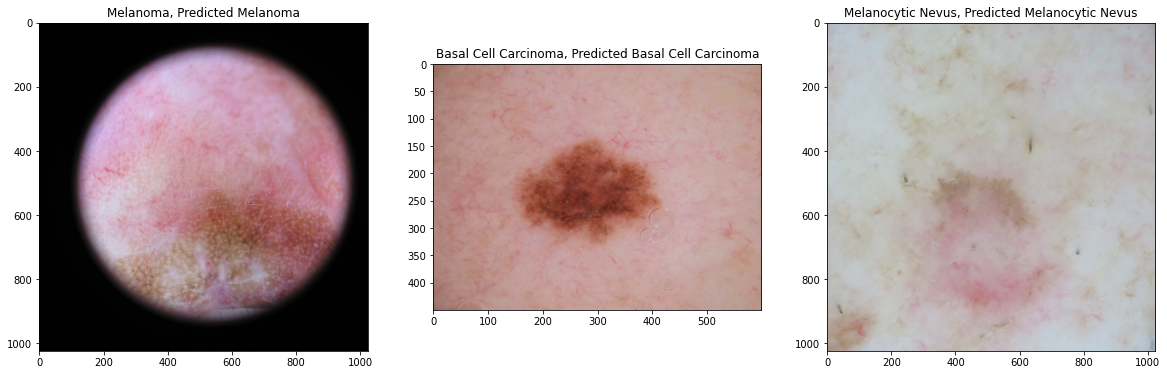

In [ ]:
# Display a few predictions, run this to qualitatively evaluate your model!
learner.display_sample_predictions()

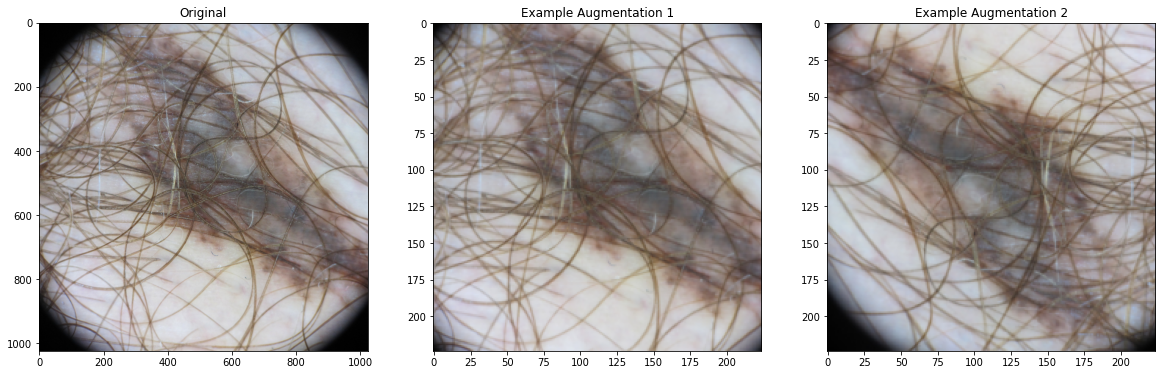

In [ ]:
# Display examples of your data augmentation scheme!
dataset.visualize_augmentation()

Batch 500/500 L: 0.307 L10: 0.632

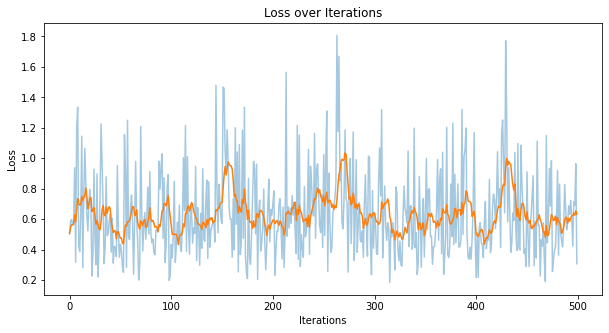

In [ ]:
'''
Train your model.  Uncomment the cache all images line if you want to
load all images before training, instead of on demand.

Make sure to set augment = True once you implement data augmentation!
'''
#dataset.cache_all_images()
learner.train_model(num_iterations = 500, augment = True)

In [ ]:
# Evaluate model!
learner.evaluate_model()

Number of Test Cases: 305
Test Loss: 0.734
Confusion Matrix
Prediction    0   1   2
Actual C 0   40  19   7 60%
Actual C 1   48 118  15 65%
Actual C 2   11   4  43 74%
             40% 83% 66%
Unweighted Accuracy : 65.90%
Weighted Accuracy: 66.65%
